In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Load Winding Dataset

Dataset Original Length n:  2499
Dataset Sampled Length n:  2499


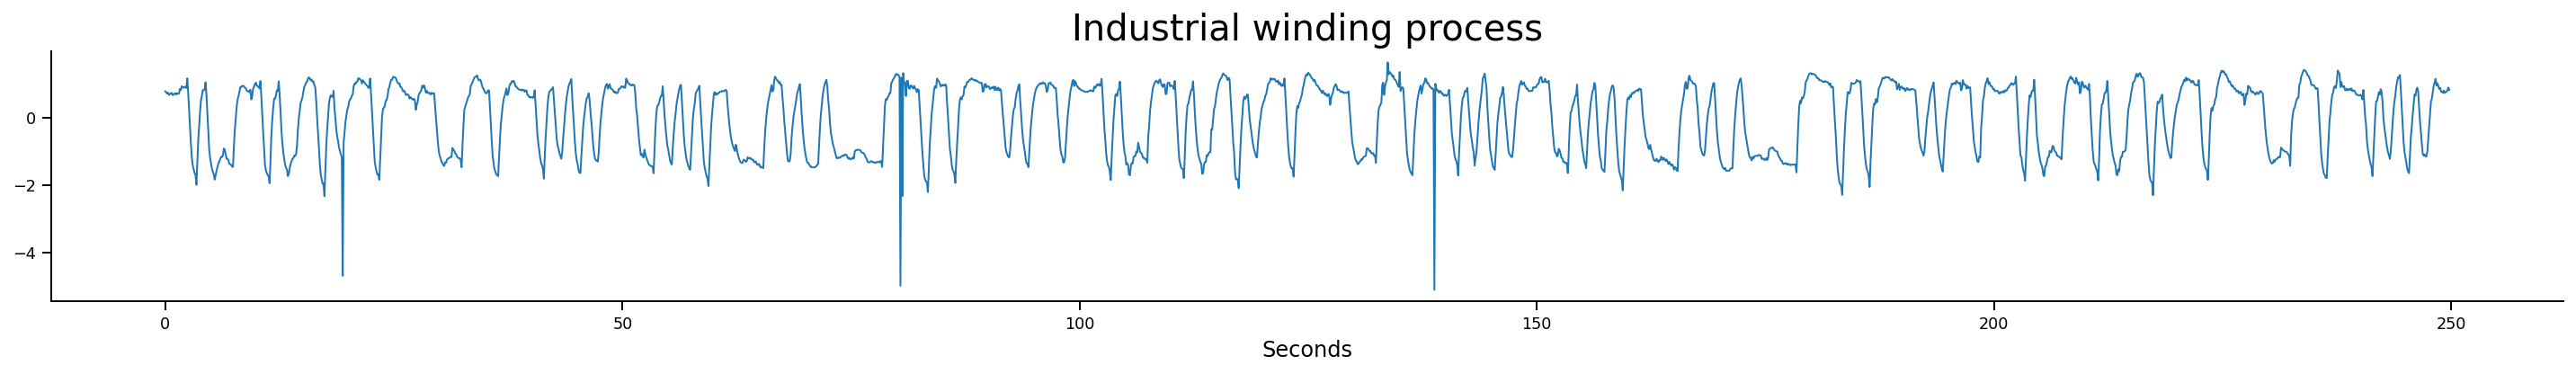

In [18]:
file = "winding_col.csv"
ds_name = "Industrial winding process"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, len(data), 1) / 10, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [19]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
motif_length = 60
ks=12
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/original/winding_col.csv


# k-Motiflets

## First, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


Chosen window-size: 60
Identified Elbow Points [ 3  6 10]
Filtered Elbow Points [6, 10]


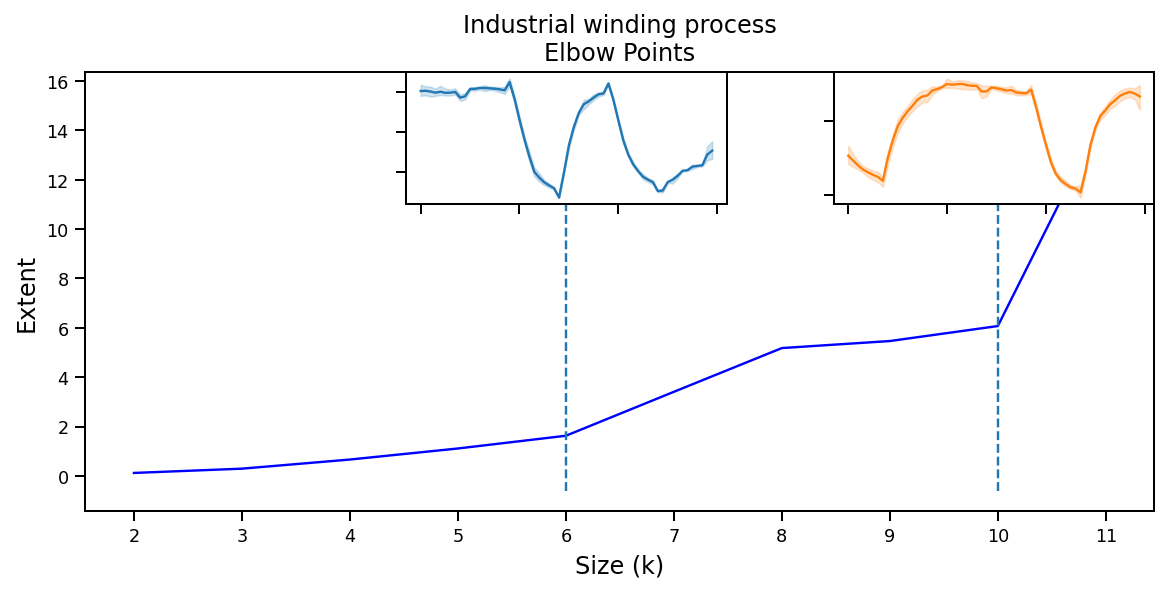

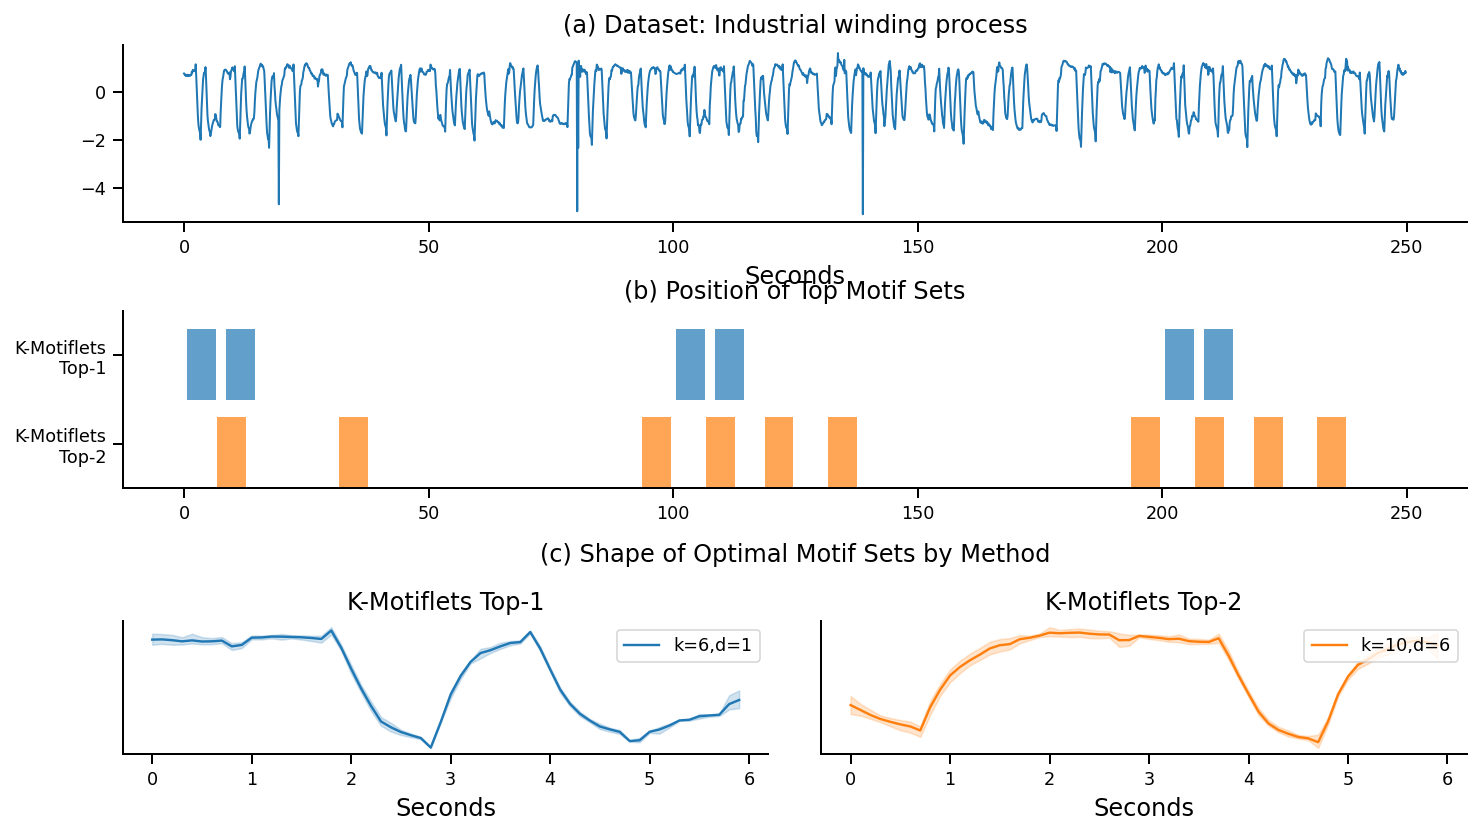

In [20]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

In [21]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 4.324788570404053 0.9148634672164917
Extent d of TOP-1 Motif 6.073066234588623


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. We pretend to have an oracle on the length l and the radius r. 

In [6]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

Radii r [0.91486347 4.32478857]


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
rs = np.array([r_top2*3, r_top1*2])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

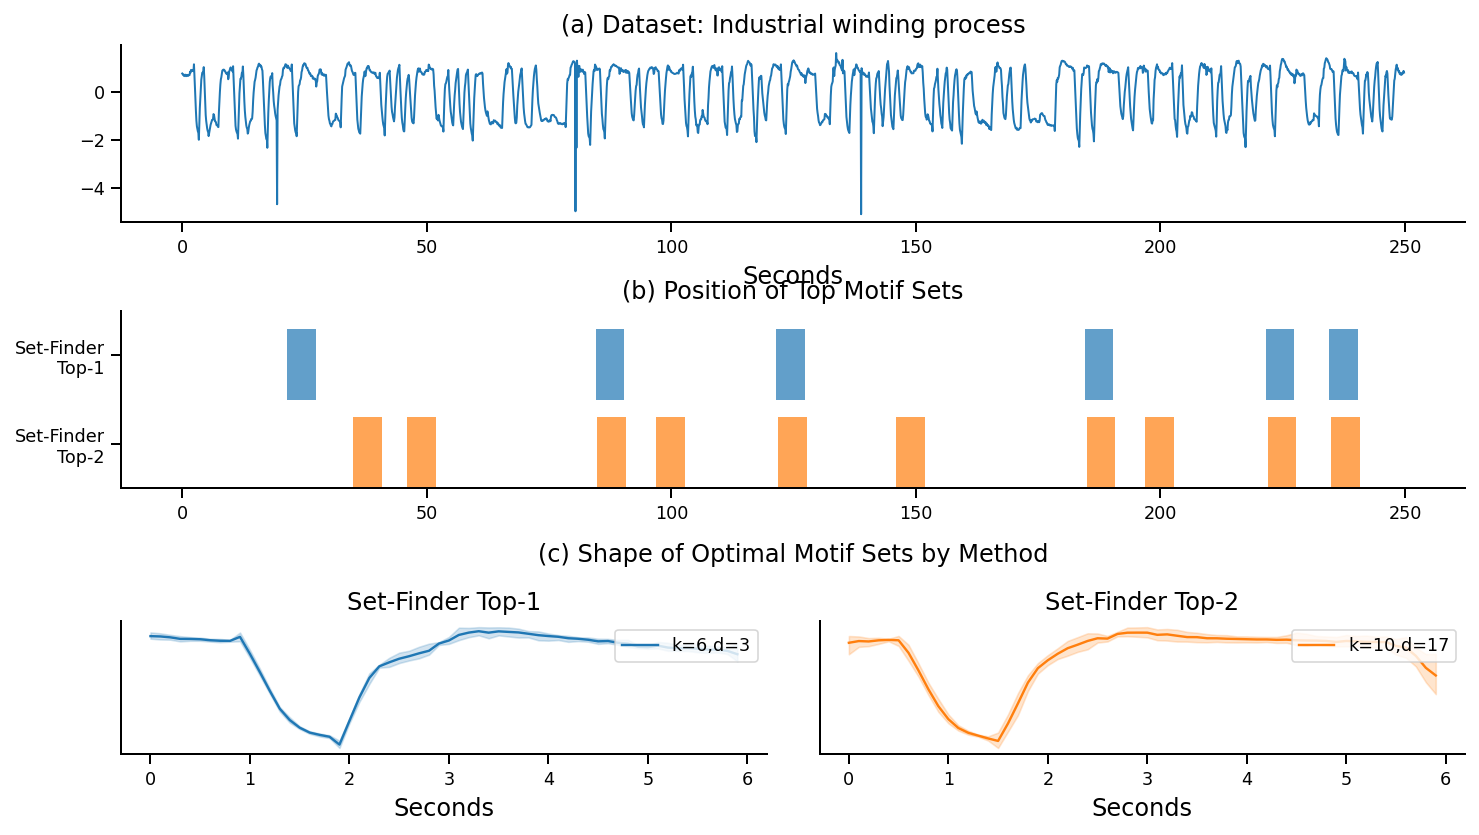

In [8]:
# run jave code first       
ms_set_finder = [
    [215, 845, 1215, 1845, 2215, 2345],
	[349, 459, 849, 968, 1219, 1459, 1849, 1968, 2219, 2348],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, 
                            filter=False, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
rs = np.array([r_top2*4, r_top1*6.5956])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

Filtered Elbow Points [0, 1]


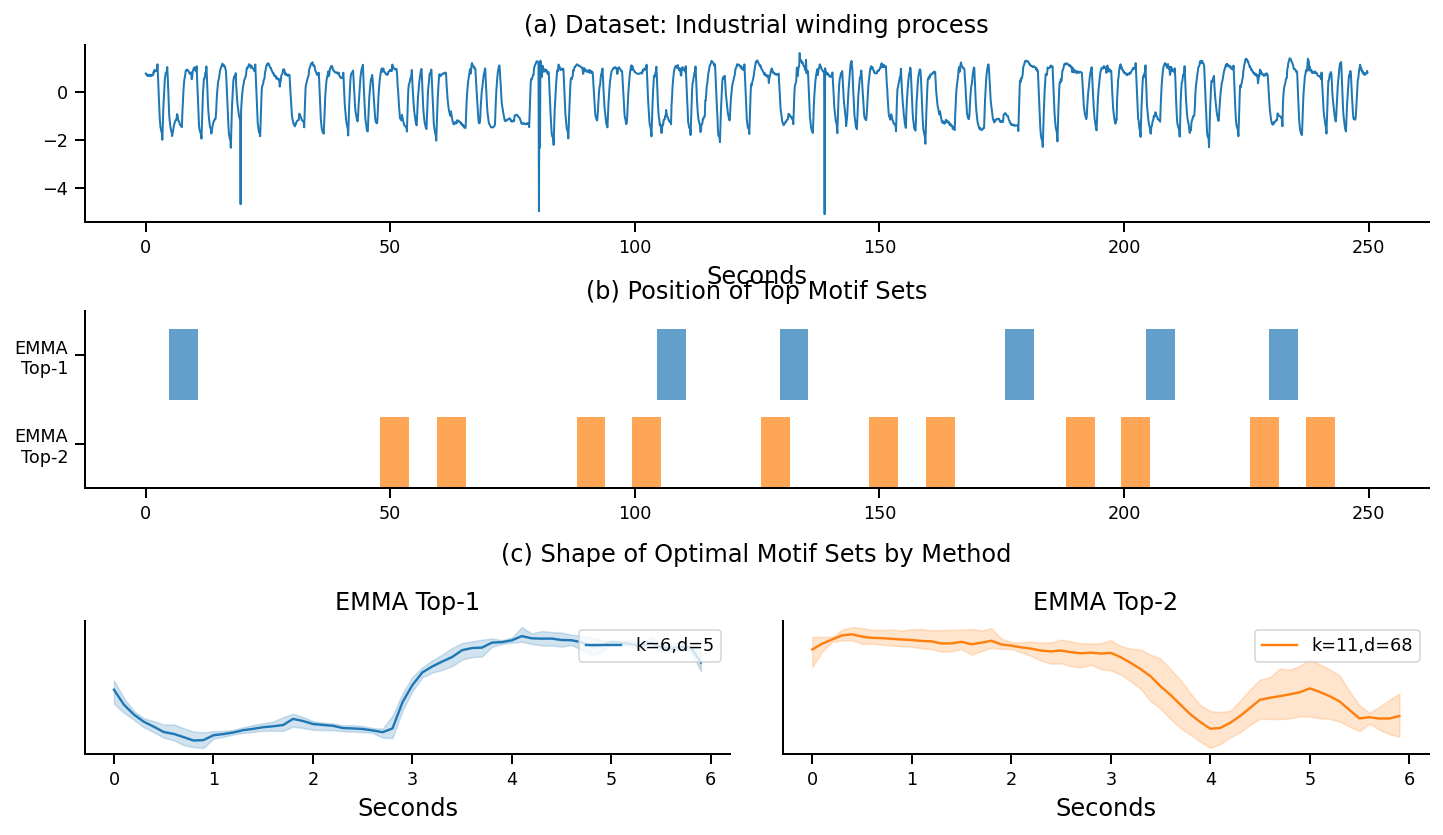

In [10]:
# run jave code first       
ms_emma = [
	[47, 1046, 1296, 1757, 2046, 2296],
	[479, 596, 881, 994, 1258, 1479, 1596, 1881, 1994, 2258, 2373],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]



# Valmod Motif Sets
based on own (fixed-length) implementation

Filtered Elbow Points [1, 2, 3]


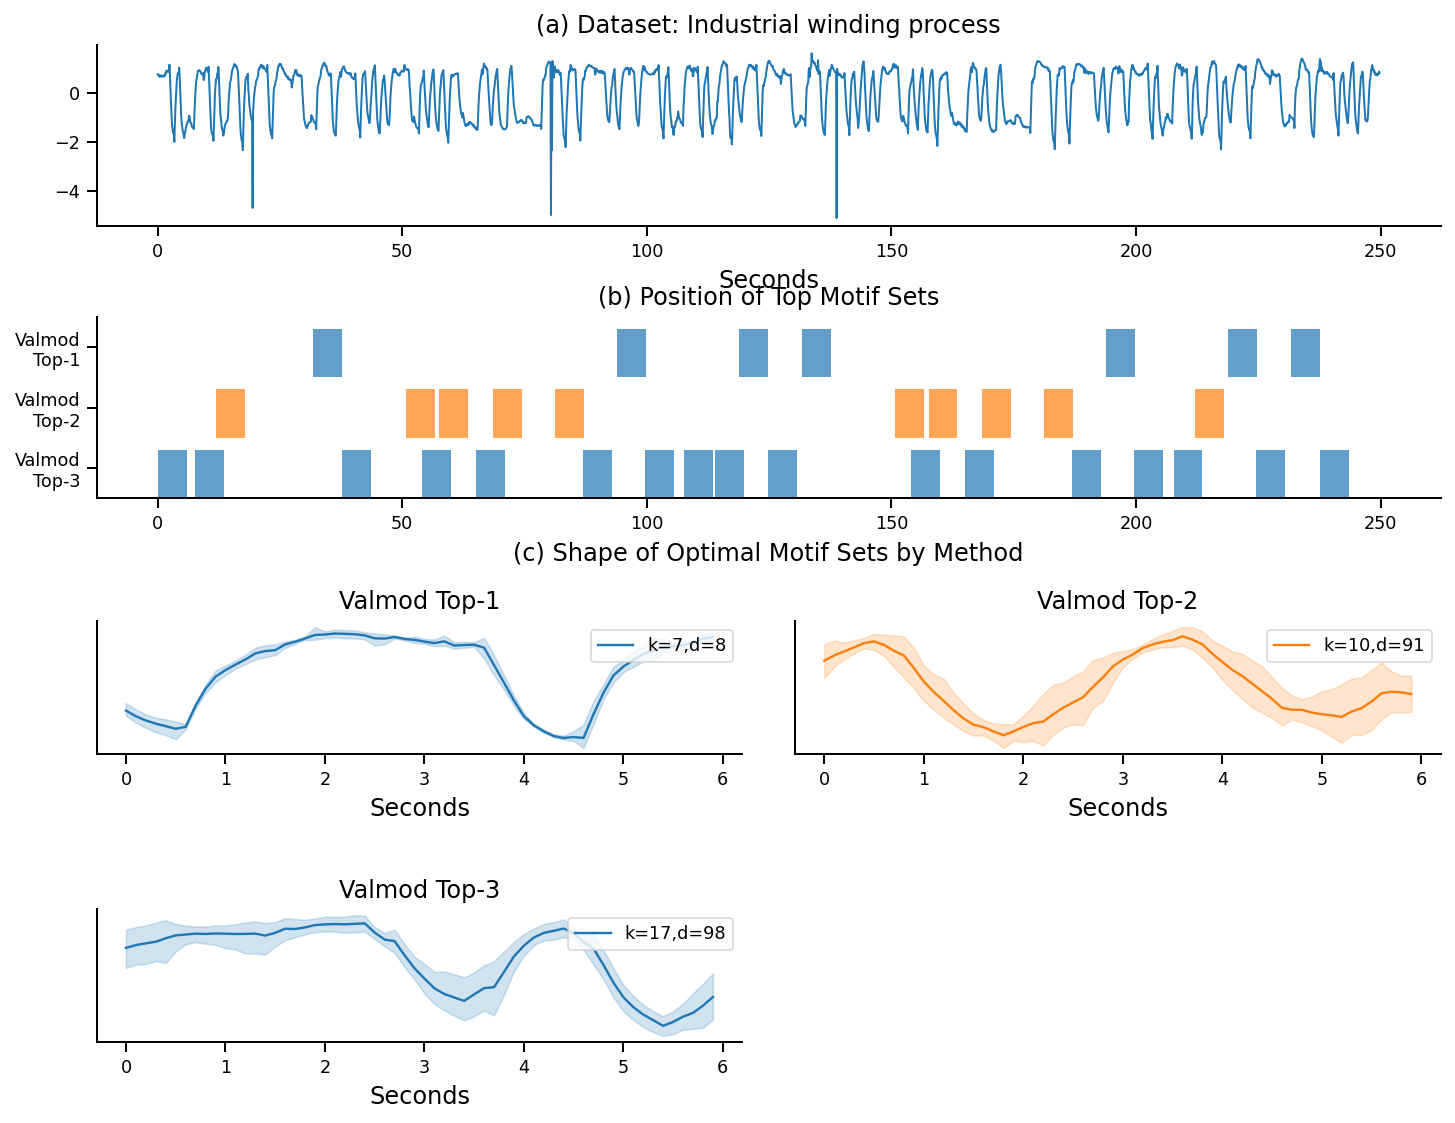

In [11]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=r_top1*10))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod", filter=True)

df["VALMOD Top-1"] = [motifset[-2]]
df2["VALMOD Top-2"] = [motifset[-3]]

# Learning Motifs
See Java Code

In [12]:
rs = np.array([r_top2*2, r_top1*2.2])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

Filtered Elbow Points [0, 1]


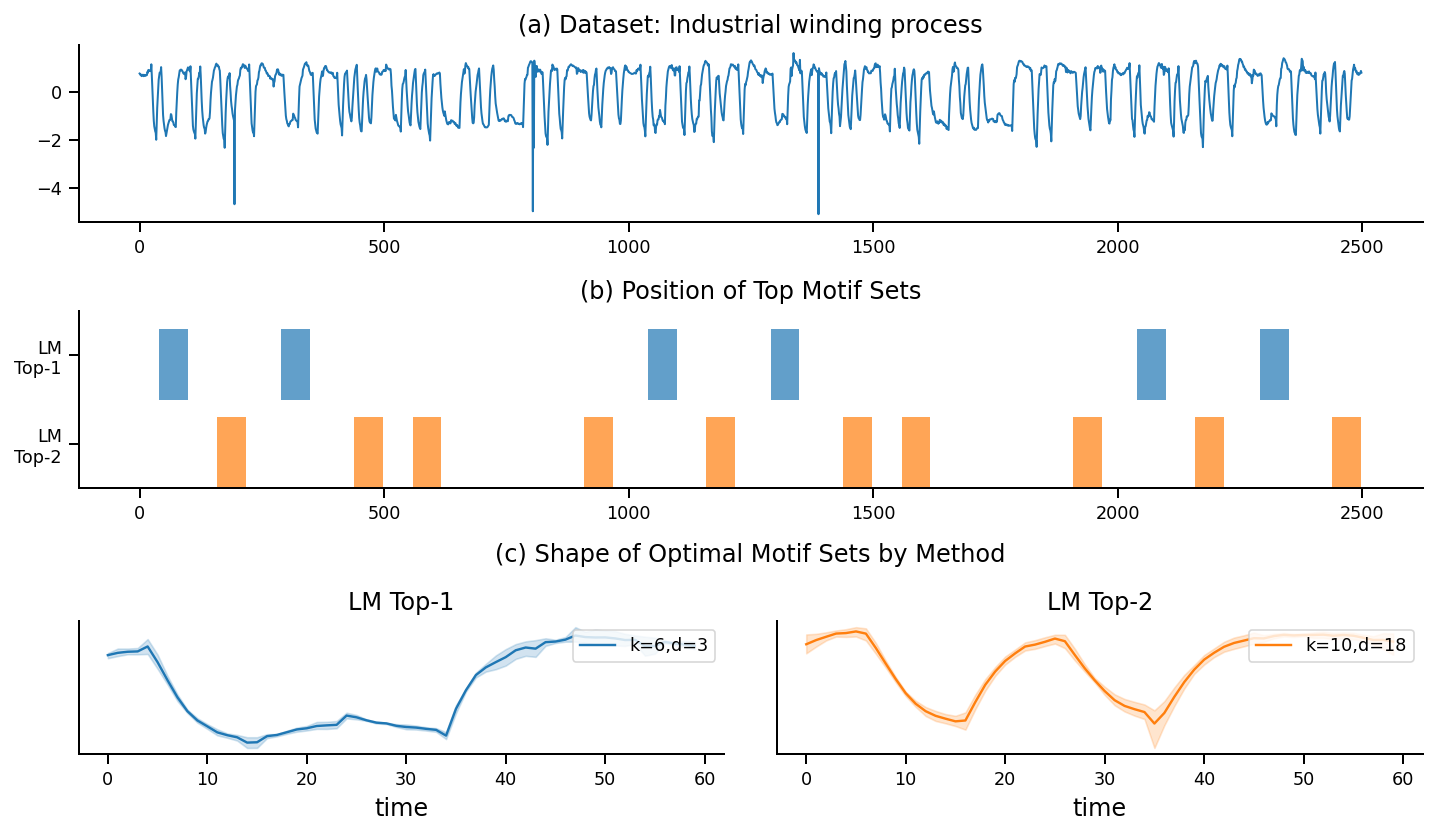

In [13]:
ms_learning_motifs = np.array([
	[40,290,1040,1290,2040,2290,],
	[159,438,558,908,1158,1438,1558,1908,2158,2438,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]


# Comparison

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[317, 2317, 1317, 2067, 2187, 1067, 1187, 67, ..."
Set Finder Top-1,"[349, 459, 849, 968, 1219, 1459, 1849, 1968, 2..."
EMMA Top-1,"[479, 596, 881, 994, 1258, 1479, 1596, 1881, 1..."
VALMOD Top-1,"[119, 508, 576, 686, 812, 1508, 1576, 1686, 18..."
LM Top-1,"[159, 438, 558, 908, 1158, 1438, 1558, 1908, 2..."
Motiflets Top-2,"[6, 1006, 2006, 86, 1086, 2086]"
Set Finder Top-2,"[215, 845, 1215, 1845, 2215, 2345]"
EMMA Top-2,"[47, 1046, 1296, 1757, 2046, 2296]"
VALMOD Top-2,"[318, 939, 1188, 1318, 1939, 2188, 2318]"
LM Top-2,"[40, 290, 1040, 1290, 2040, 2290]"


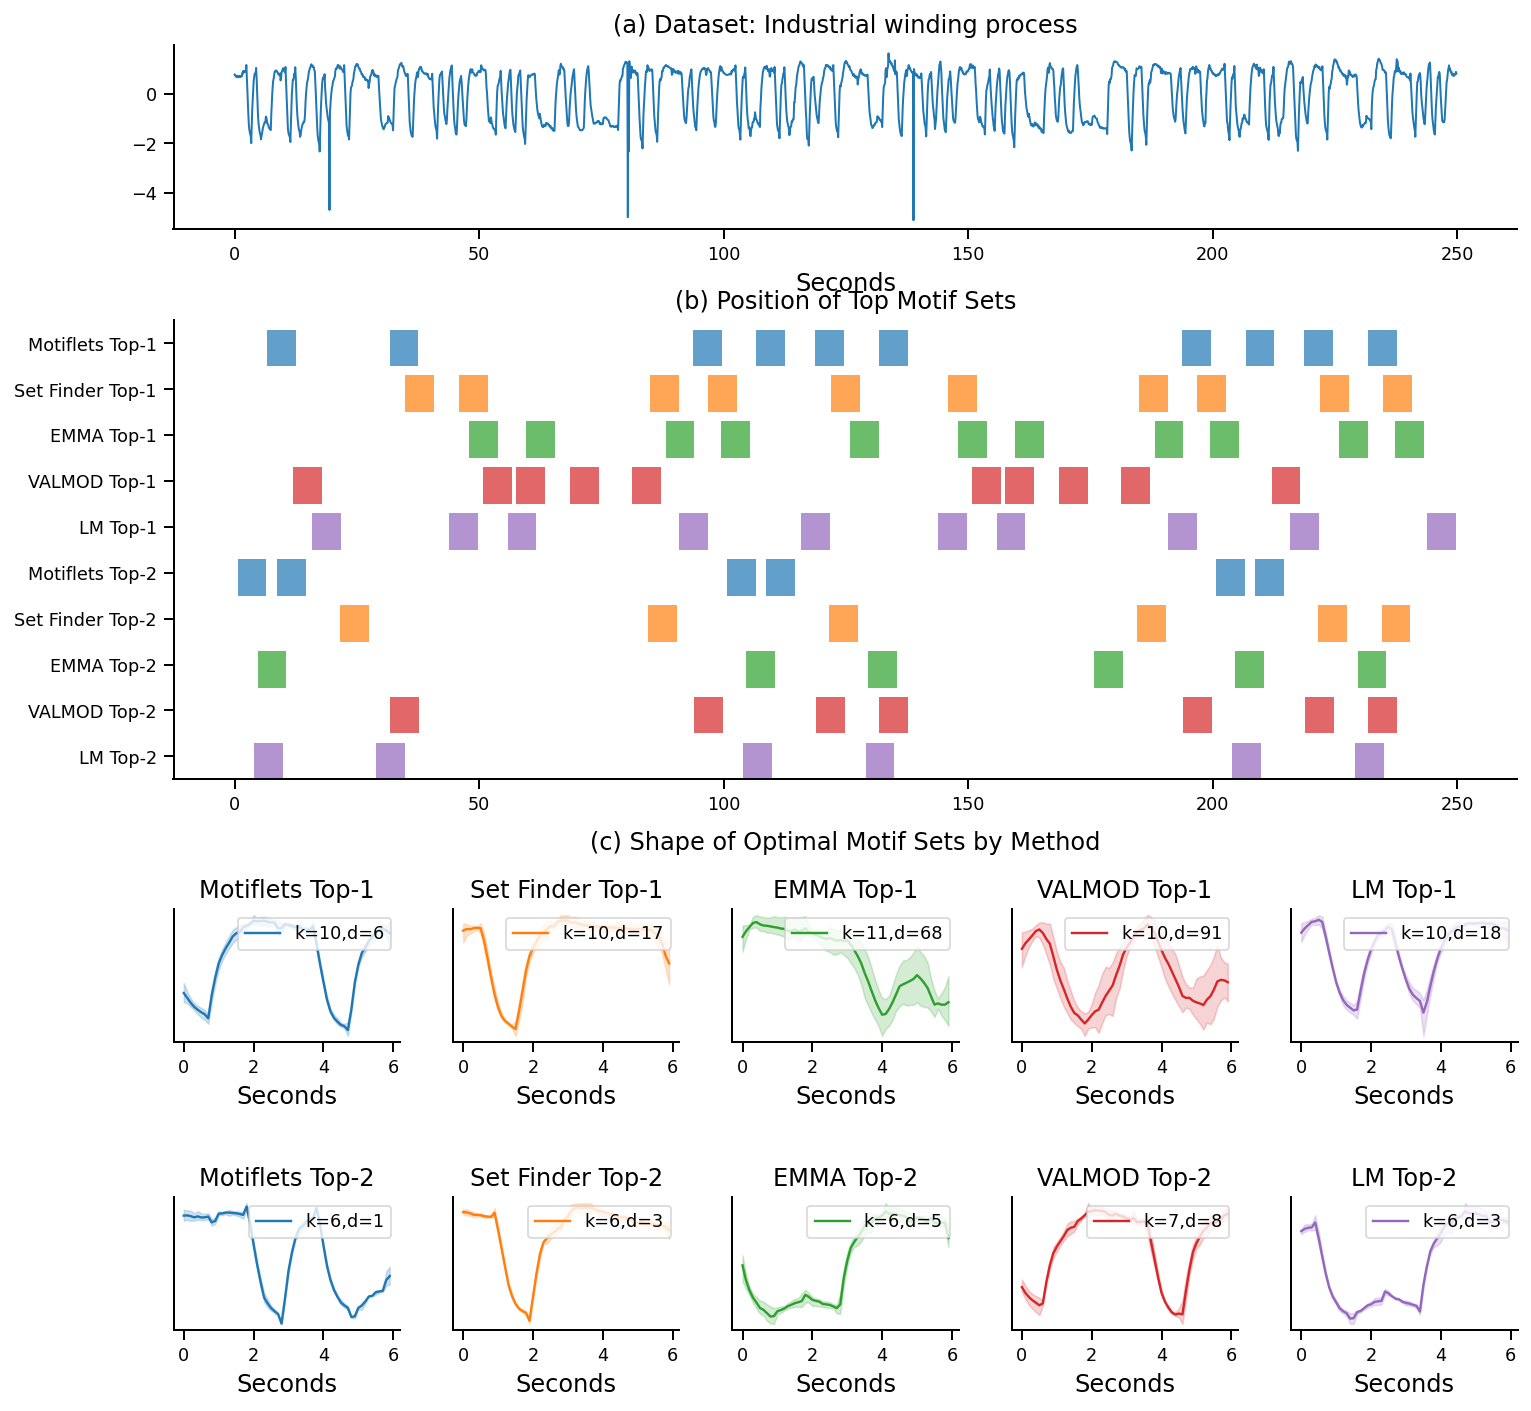

In [16]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)